# Waterfront Analysis

## Contents

1. Purpose
2. Importing
3. Load and Pre-Process Data
4. Data Analysis and Visualizations
5. Takeaways

## Purpose

The Purpose of this notebook is to investigate the industry claim that having a waterfront property increases home sale price. For our Purpose

## Process

- Subset and preprare the waterfront data of interest for analysis
- Compare median sale prices of homes with and without a waterfront
- Create a linear regression model
- Test the hypothesis

## Importing

In [1]:
#Auto reload for src function testing
#Add the project directory to our module path
%load_ext autoreload
%autoreload 2
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Modules
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from src import data_cleaning

# Directiory Paths
data_folder = '../../data/'
fig_folder = '../../reports/figures/'

# Import Functions
from src import cm_functions

## Load and Pre-Process Data

First we load in our three data sets: Property Sales, Parcels, and Residential Buildings. Please run notebook "00_mef_initial_data_cleaning" where the steps are outlined in detail. 

In [2]:
sales = pd.read_csv(data_folder+'EXTR_RPSale_final.csv',dtype={'Major': 'string', 'Minor':'string', 'PIN': 'string'})
parcels = pd.read_csv(data_folder+'EXTR_Parcel_final.csv',dtype={'Major': 'string', 'Minor':'string', 'PIN': 'string'})
res_bldg = pd.read_csv(data_folder+'EXTR_ResBldg_final.csv', dtype={'Major':'string', 'Minor':'string', 'PIN':'string'})
print(sales.shape, parcels.shape, res_bldg.shape)


/opt/anaconda3/envs/oy-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(28625, 77) (27866, 83) (27866, 53)


Function to clean the data per the steps outlined in detail in "00_mef_initial_data_cleaning" notebook. 

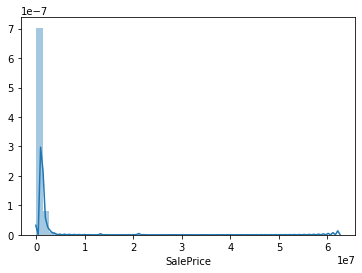

In [3]:
sr_df = pd.merge(sales, res_bldg, on='PIN', how='inner', suffixes=('_sales', '_res'))
srp_df = pd.merge(sr_df, parcels, on='PIN', how='inner', suffixes=('_sales', '_res'))
sns.distplot(srp_df.SalePrice)

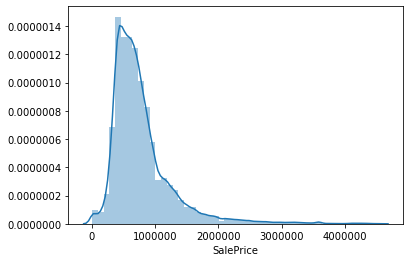

In [4]:
z = np.abs(stats.zscore(srp_df.SalePrice))
srp_df = srp_df[z < 3]

sns.distplot(srp_df.SalePrice)

## Additional Data Processing

Let's make wfnt_df our waterfront dataframe and set the WfntLocation column as a category

In [5]:
wfnt_df = srp_df.loc[:,['SalePrice', 'WfntLocation']]
wfnt_df.WfntLocation = wfnt_df.WfntLocation.astype('category')
wfnt_df.WfntLocation.value_counts()

0    28060
8      129
3       87
6       80
9       76
7       34
5        7
1        2
4        1
Name: WfntLocation, dtype: int64

Now lets set the category numbers to their values using the look up table: 

| CATEGORY # |  |
|-|-|
| 0 | NO WATERFRONT |
| 1 | DUWAMISH |
| 2 | ELLIOT BAY |
| 3 | PUGET SOUND |
| 4 | LAKE UNION |
| 5 | SHIP CANAL |
| 6 | LAKE WASHINGTON |
| 7 | LAKE SAMM |
| 8 | OTHER LAKE |
| 9 | RIVER/SLOUGH |

In [6]:
cat_dict = {0:'NOT WATERFRONT',1:'DUWAMISH',3:'PUGET SOUND',4:'LAKE UNION',5:'SHIP CANAL',6:'LAKE WASHINGTON',7:'LAKE SAMM',8:'OTHER LAKE',9:'RIVER SLOUGH'}
df_copy = wfnt_df
df_copy['WfntLocation'] = pd.Categorical(df_copy['WfntLocation'].map(cat_dict))

In [7]:
wfnt_df.WfntLocation.value_counts()

NOT WATERFRONT     28060
OTHER LAKE           129
PUGET SOUND           87
LAKE WASHINGTON       80
RIVER SLOUGH          76
LAKE SAMM             34
SHIP CANAL             7
DUWAMISH               2
LAKE UNION             1
Name: WfntLocation, dtype: int64

## Data Analysis and Visualizations

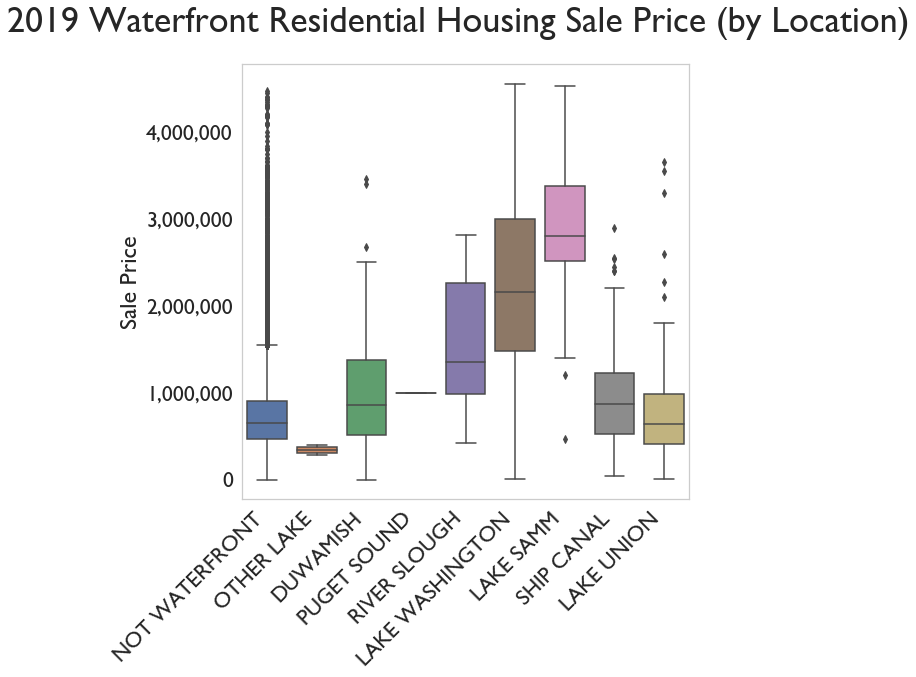

In [8]:
import matplotlib as mpl
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
sns.set_style({'font.family':'Gill Sans MT', 'font.sans-serif':['Gill Sans']})
sns.set(font_scale=2)
sns.set_style("whitegrid")
loc_wfnt_labels = wfnt_df['WfntLocation'].unique()
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111)
loc_wfnt_boxplot = sns.boxplot(x=wfnt_df["WfntLocation"], y=wfnt_df["SalePrice"], data=wfnt_df,  ax=axes).set(xlabel=None, ylabel='Sale Price')
fig.suptitle('2019 Waterfront Residential Housing Sale Price (by Location)', fontsize=36)
axes.set_xticklabels(loc_wfnt_labels,rotation=45,ha='right');
sns.set_style({'font.family':'Gill Sans MT', 'font.sans-serif':['Gill Sans']})
axes.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
axes.grid(False)
fig.savefig(fig_folder+'wfnt_loc_boxplot.png', transparent=True,dpi=300, bbox_inches = "tight");

Create a column that tells us weather or not it is a waterfront property.

In [9]:
wfnt_df['is_waterfront'] = (srp_df['WfntLocation'] != 0).astype('int')
wfnt_df['is_waterfront'].value_counts()

0    28060
1      416
Name: is_waterfront, dtype: int64

In [10]:
cat_dict = {0:'NOT WATERFRONT',1:'WATERFRONT'}
wfnt_df['is_waterfront'] = pd.Categorical(wfnt_df['is_waterfront'].map(cat_dict))
wfnt_df.is_waterfront.unique()

[NOT WATERFRONT, WATERFRONT]
Categories (2, object): [NOT WATERFRONT, WATERFRONT]

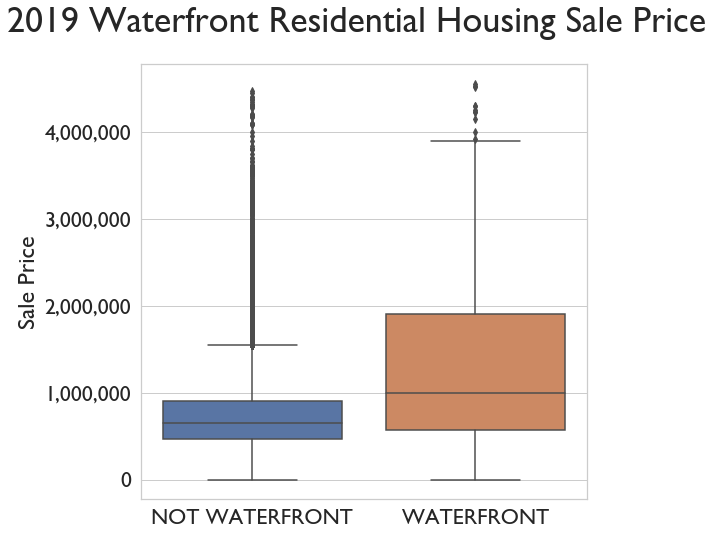

In [11]:
import matplotlib as mpl
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
sns.set_style({'font.family':'Gill Sans MT', 'font.sans-serif':['Gill Sans']})
sns.set(font_scale=2)
sns.set_style("whitegrid")
is_wfnt_labels = wfnt_df['is_waterfront'].unique()
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111)

is_wfnt_boxplot = sns.boxplot(x=wfnt_df["is_waterfront"], y=wfnt_df["SalePrice"], data=wfnt_df,  ax=axes).set(
    xlabel=None, 
    ylabel='Sale Price'
)

fig.suptitle('2019 Waterfront Residential Housing Sale Price', fontsize=36)

sns.set_style({'font.family':'Gill Sans MT', 'font.sans-serif':['Gill Sans']})
axes.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
fig.savefig(fig_folder+'is_wfnt_boxplot.png', transparent=True,dpi=300, bbox_inches = "tight");

In [12]:
no_wfnt = wfnt_df[wfnt_df['is_waterfront']=='NOT WATERFRONT']
wfnt = wfnt_df[wfnt_df['is_waterfront']=='WATERFRONT']

Subset the data

In [13]:
wfnt_median = wfnt.SalePrice.median()
no_wfnt_median = no_wfnt.SalePrice.median()
print(f'median value of homes w/ waterfront: {wfnt_median}')
print(f'median value of homes w/o waterfront: {no_wfnt_median}\n')

print(f'Homes that have a waterfront have a median value of about ${abs(wfnt_median-no_wfnt_median)} higher than homes that don\'t have one.')

median value of homes w/ waterfront: 995000.0
median value of homes w/o waterfront: 652500.0

Homes that have a waterfront have a median value of about $342500.0 higher than homes that don't have one.


findfont: Font family ['Gill Sans MT'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Gill Sans MT'] not found. Falling back to DejaVu Sans.


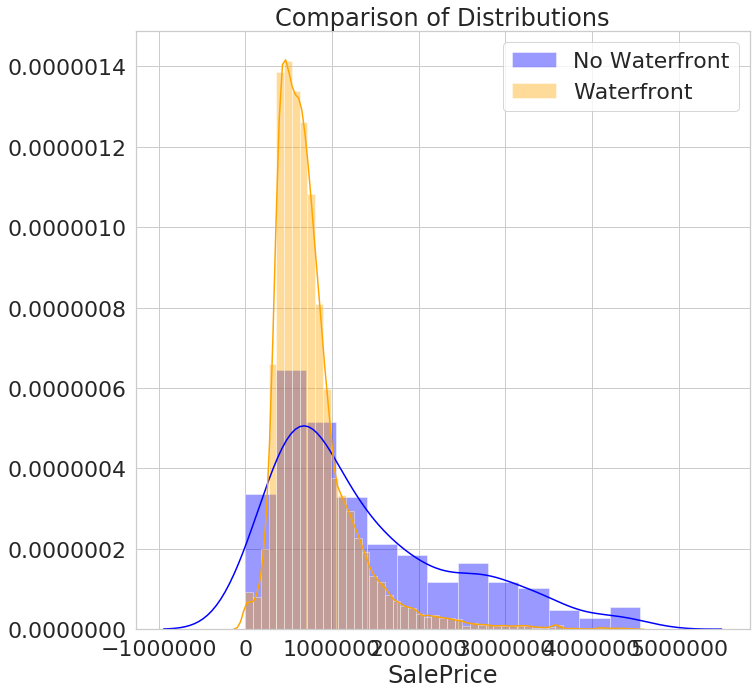

In [14]:
fig, ax = plt.subplots(1,1,figsize=(11,11))

sns.distplot(wfnt.SalePrice, ax=ax, color='blue', label='No Waterfront')
sns.distplot(no_wfnt.SalePrice, ax=ax, color='orange', label='Waterfront')
ax.legend()
ax.set_title('Comparison of Distributions');

N0: The 2019 median sale price of King County homes that have a waterfront is the same or lower than homes that do not.

NA: The 2019 median sale price of King County homes that have a waterfront is higher that homes that do not.

In [15]:
stats.ttest_ind(wfnt.SalePrice, no_wfnt.SalePrice, equal_var=False)

Ttest_indResult(statistic=11.311885171451998, pvalue=4.6344496150042865e-26)

## Takeaways

* Since the median value is higher for waterfront property there is evidence that the industry claim is true.